<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Section-5-6-7.3" data-toc-modified-id="Section-5-6-7.3-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Section 5-6-7.3</a></span><ul class="toc-item"><li><span><a href="#Question-1" data-toc-modified-id="Question-1-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Question 1</a></span></li><li><span><a href="#Question-2" data-toc-modified-id="Question-2-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Question 2</a></span></li><li><span><a href="#Question-3" data-toc-modified-id="Question-3-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Question 3</a></span></li><li><span><a href="#Question-4" data-toc-modified-id="Question-4-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Question 4</a></span></li><li><span><a href="#Question-5" data-toc-modified-id="Question-5-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Question 5</a></span></li><li><span><a href="#Question-6" data-toc-modified-id="Question-6-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Question 6</a></span></li><li><span><a href="#Question-7" data-toc-modified-id="Question-7-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Question 7</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize
import seaborn as sns
import arviz as az
import xarray as xr

config = {
    'figure.facecolor':'w',
    'axes.grid':True,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'figure.constrained_layout.use':True
}

plt.rcParams.update(config)

# Section 5-6-7.3

Two Risky Assets Portfolio, Captal Market Line and Risk Measures based on Quantiles

The risk-free rate (which can be used to borrow or invest) is assumed to be 3.5%.

Using long-time series, you have estimated the main characteristics associated with the returns of two mutual funds:

|                  | Fund 1       | Fund 2       |
|------------------|-------------|-------------|
| Expected Return  | $$E(r_1) = 20\%$$ | $$E(r_2) = 5\%$$ |
| Variance         | $$\sigma^2(r_1) = 0.0625$$ | $$\sigma^2(r_2) = 0.04$$ |

The correlation coefficient between the returns of Fund 1 and Fund 2 is $\rho_{12} = -0.4$.

For an initial level of wealth $W_0$, the part invested in the risky portfolio is denoted $\alpha$, and thus $1 - \alpha$ is the proportion invested in the risk-free asset. If $W_1$ is the amount invested in risky assets, then $\delta$ is the proportion invested in asset 1, and $1 - \delta$ is the part invested in asset 2.

## Question 1

Using respective values of $\delta = 0, 0.25, 0.5, 0.75$, and $1$, calculate the characteristics (expected return / risk) of the two risky assets portfolio (invested in assets 1 and 2).

As usual, we need to recall the formuals for mean and variance of the portfolios. Remember that these just come from the shifting-scaling rules, together with the convolution of normals:

$$
\begin{align}
\mu &= \delta \mu_1 + (1 - \delta) \mu_2 \\
\sigma^2 &= \delta^2 \sigma_1^2 + (1 - \delta)^2 \sigma_2^2 + 2 \rho \delta (1 - \delta) \sigma_1 \sigma_2 
\end{align}
$$

**Make a dataframe to hold the question data**

In [95]:
df = pd.DataFrame(np.array([[0.2, 0.05], [0.0625, 0.04]]), columns=['Fund 1', 'Fund 2'], index=['mean', 'variance'])
rho = -0.4
df

,Fund 1,Fund 2
mean,0.2000,0.05
variance,0.0625,0.04


**Write some functions to compute the first two moments**

In [125]:
def portfolio_mean(delta, mus):
    deltas = np.c_[delta, 1 - delta]
    return (deltas * mus).sum(axis=-1)

def portfolio_variance(delta, sigmas_sq, rho):
    deltas = np.c_[delta, 1 - delta]
    
    sigma_terms = (deltas ** 2 * sigmas_sq).sum(axis=-1)
    cross_term = 2 * rho * np.prod(np.sqrt(sigmas_sq)) * deltas.prod(axis=-1)
    
    return sigma_terms + cross_term

def portfolio_moments(delta, df, rho):
    mus = df['mean'].values
    sigmas_sq = df['variance'].values
    data = np.r_[[portfolio_mean(delta, mus)],
             [portfolio_variance(delta, sigmas_sq, rho)]]
    solution_df = pd.DataFrame(data, index=['mean', 'variance'], columns=delta.ravel())
    solution_df.columns.name = 'Asset 1 weight'
    solution_df = solution_df.T.assign(std = lambda x: x['variance'] ** 0.5).round(4).sort_index(ascending=False)
    return solution_df

**Compute the portfolio moments**

In [126]:
weights = np.array([0, 0.25, 0.5, 0.75, 1]).reshape(-1, 1)
solution_df = portfolio_moments(weights, df.T, rho)
solution_df

,mean,variance,std
Asset 1 weight,,,
1.00,0.2000,0.0625,0.2500
0.75,0.1625,0.0302,0.1737
0.50,0.1250,0.0156,0.1250
0.25,0.0875,0.0189,0.1375
0.00,0.0500,0.0400,0.2000


## Question 2
Plot the minimum variance frontier

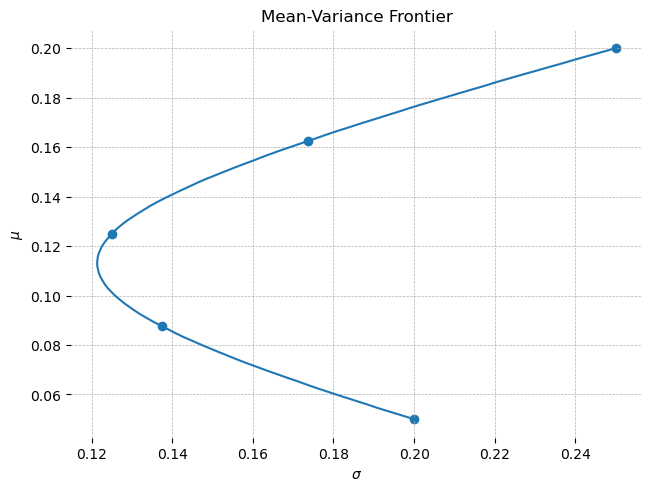

In [190]:
fig, ax = plt.subplots()
more_weights = np.linspace(0, 1, 100)
mvf_df = portfolio_moments(more_weights, df.T, rho)
ax.plot(mvf_df['std'], mvf_df['mean'])
ax.scatter(solution_df['std'], solution_df['mean'])
ax.set(xlabel='$\sigma$', ylabel='$\mu$', title='Mean-Variance Frontier')
plt.show()

## Question 3

What are the variance-minimizing portfolio weights?

Recall the formula we derived last time:

$$w = \frac{\sigma_b^2 - \rho \sigma_a \sigma_b}{\sigma^2_a + \sigma_b^2 - 2 \rho \sigma_a \sigma_b}$$

In [128]:
def compute_w_star(s2_1, s2_2, rho):
    s1, s2 = s2_1 ** 0.5, s2_2 ** 0.5
    cross_term = rho * s1 * s2
    
    top = s2_2 - cross_term
    bot = s2_1 + s2_2 - 2 * cross_term
    return top / bot

In [129]:
w_star = compute_w_star(*df.loc['variance'].values, rho)
print(f'Minimum variance Asset 1 allocation: {w_star:0.3f}')

Minimum variance Asset 1 allocation: 0.421


## Question 4

What are the moments of the minimum variance portfolio?

In [130]:
portfolio_star = pd.Series({'mean':portfolio_mean(w_star, df.loc['mean'].values)[0],
                            'variance':portfolio_variance(w_star, df.loc['variance'].values, rho)[0]})
portfolio_star['std'] = portfolio_star['variance'] ** 0.5
portfolio_star

mean        0.113158
variance    0.014737
std         0.121395
dtype: float64

## Question 5
Plot the minimum variance portfolio and the captial market line.

IMO this question is messed up. To get the tangency portfolio, this is the formula:

$$w_{\text{tan}} = \frac{\rho \sigma_{a} \sigma_{b} \left(\mu_{b} - r_{f}\right) + \sigma_{b}^{2} \left(- \mu_{a} + r_{f}\right)}{\rho \sigma_{a} \sigma_{b} \left(\mu_{a} + \mu_{b} - 2 r_{f}\right) + \sigma_{a}^{2} \left(- \mu_{b} + r_{f}\right) + \sigma_{b}^{2} \left(- \mu_{a} + r_{f}\right)}$$

There's no way you're supposed to memorize this. Please don't. To be honest, I'd do this question by eyeballing it -- try to draw the capital market line with a ruler, and then estimate what the tangency portfolio is.

Anyway, here's the exact computer solution.

In [200]:
def compute_w_tan(mu_a, mu_b, s_a, s_b, rf, rho):
    # Compute the weight associated with the tangency portfolio
    # For details, see the TD05 notebook
    ex_a = mu_a - rf
    ex_b = mu_b - rf
    s2_a = s_a ** 2
    s2_b = s_b ** 2
    cross = rho * s_a * s_b
    
    top = cross * ex_b - s2_b * ex_a
    bot = cross * (mu_a + mu_b - 2 * rf) - s2_a * ex_b - s2_b * ex_a
    
    return top / bot

def capital_market_line(w_tan, weights, df, rf, rho):
    # Compute the capital market line.
    # Do this by forming portfolios of the tangency portfolio with the risk-free asset.
    # So there are two weights: One is the tangency weight, to make the risky asset portfolio
    # The second is "alpha", the amount of risky asset in the portfolio.
    
    tan_portfolio = portfolio_moments(w_tan, df, rho)
    tan_portfolio.loc['risk-free'] = pd.Series({'mean':rf, 'variance':0, 'std':0})
    tan_portfolio.index = ['tan_portfolio', 'risk_free']
    market_portfolios = portfolio_moments(weights, tan_portfolio, 0)
    return market_portfolios
    

**Use the above functions to compute the tangency portfolio**

In [201]:
rf = 0.035
w_tan = compute_w_tan(*df.loc['mean'].values, *df.loc['variance'].values ** 0.5, rf, rho)
print(f'Weight of the tangency portfolio: {w_tan}')

Weight of the tangency portfolio: 0.6195286195286196


**Compute some stuff to plot**

- `alpha_weights` is a range of weights to make the capital market line
- `cml_portfolios` will be what we actually plot as the CML
- `tan_portfolio` give the moments of the tangency portfolio

In [197]:
alpha_weights = np.linspace(0, 2, 100)
cml_portfolios = capital_market_line(w_tan, alpha_weights, df.T, rf, rho)
tan_portfolio = portfolio_moments(w_tan, df.T, rho)
tan_portfolio.index = ['tangency']

**Do the plotting**

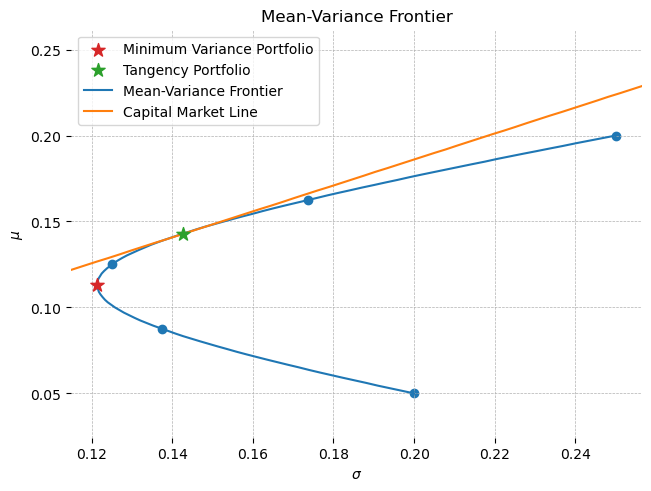

In [198]:
fig, ax = plt.subplots()
ax.scatter(solution_df['std'], solution_df['mean'])
ax.scatter(portfolio_star['std'], portfolio_star['mean'], marker='*', color='tab:red', zorder=10, s=100, label='Minimum Variance Portfolio')
ax.scatter(tan_portfolio['std'], tan_portfolio['mean'], marker='*', color='tab:green', zorder=10, s=100, label='Tangency Portfolio')

xlims, ylims = ax.get_xlim(), ax.get_ylim()
ax.plot(mvf_df['std'], mvf_df['mean'], label='Mean-Variance Frontier')
ax.plot(cml_portfolios['std'], cml_portfolios['mean'], label='Capital Market Line')

sigma_grid = np.linspace(0.12, 0.24, 100)
ax.set(xlabel='$\sigma$', ylabel='$\\mu$', title='Mean-Variance Frontier', xlim=xlims)
ax.legend()
plt.show()

## Question 6

Compute the sharpe value associated with the tangency portfolio. Here's a formula you **do** need to know:

$$s = \frac{\mu - r_f}{\sigma}$$

In [202]:
tan_portfolio['sharpe'] = (tan_portfolio['mean'] - rf) / tan_portfolio['std']
tan_portfolio

,mean,variance,std,sharpe
tangency,0.1429,0.0204,0.1427,0.756132


## Question 7

Assuming now that an investor has a risk aversion coefficient $A = 10$ and a Mean-variance utility function. Determine the value $\alpha^*$ and the characteristics $(\mu_x, \sigma_x)$ of this optimal portfolio. Calculate also the level associated with this utility function.

First we need a formula for utility maximizing weights. Recall that the formula for MVU is:

$$U = \mu - \frac{A}{2}\sigma^2$$

And we know that:

$$
\begin{align}
\mu &= \alpha \mu_\text{tan} + (1 - \alpha) r_f\\
\sigma^2 &= \alpha^2 \sigma^2_{\text{tan}}
\end{align}
$$

The $\sigma^2$ expression is simplified by the fact that $r_f$ has no variance, which is great!

Anyway, plug these into the MVU formula and take the derivative with respect to $\alpha$:

$$\max_\alpha \alpha \mu_\text{tan} + (1 - \alpha) r_f - \frac{A}{2} \alpha^2 \sigma^2_{\text{tan}}$$

First order condition:

$$\mu_\text{tan} - r_f - A \alpha \sigma^2_{\text{tan}} = 0$$

Solve for $\alpha^\star$:

$$\alpha^\star = \frac{\mu_\text{tan} - r_f}{A \sigma^2_{\text{tan}}}$$

In [212]:
A = 10
alpha_star_10 = (tan_portfolio['mean'] - rf) / A / tan_portfolio['variance']
alpha_star_10

tangency    0.528922
dtype: float64

In [215]:
tan_portfolio2 = portfolio_moments(w_tan, df.T, rho)
tan_portfolio2.loc['risk-free'] = pd.Series({'mean':rf, 'variance':0, 'std':0})

In [218]:
U_max_portfolio = portfolio_moments(alpha_star_10, tan_portfolio2, 0)
U_max_portfolio.index = ['max utility']
U_max_portfolio

,mean,variance,std
max utility,0.0921,0.0057,0.0755


In [219]:
U_max_portfolio['mean'] - A / 2 * U_max_portfolio['variance']

max utility    0.0636
dtype: float64